# **Analiza wielokryterialna wyboru laptopa metodą TOPSIS**

### Opis ogólny

Celem niniejszej analizy jest wybranie najlepszego laptopa spośród pewnego zbioru modeli na podstawie wielu kryteriów jednocześnie (np. liczba rdzeni, taktowanie CPU, wielkość SSD, RAM, czas baterii, cena, ocena użytkowników). 

Do tego zadania zastosujemy metodę **TOPSIS** (*Technique for Order Preference by Similarity to Ideal Solution*), która polega na:

1. **Normalizacji** danych wejściowych (by były porównywalne).
2. **Zastosowaniu wag** dla poszczególnych kryteriów.
3. **Wyznaczeniu punktów idealnych i anty-idealnych** (najlepszy i najgorszy możliwy wariant).
4. **Obliczeniu odległości** każdej alternatywy (laptopa) od ideału i anty-ideału.
5. **Wyliczeniu współczynnika bliskości** do ideału.
6. **Utworzeniu rankingu** według tej miary.

W notatniku kolejno:
- Wczytamy i przygotujemy dane z pliku Excel.
- Wskażemy, które kryteria są **korzystne** (beneficial), a które **kosztowe** (cost).
- Określimy wagi tych kryteriów.
- Dokonamy obliczeń metodą TOPSIS.
- Pokażemy **ranking** najkorzystniejszych laptopów.
- Zobrazujemy wyniki na wykresie.

---


In [32]:
# =====================================================================
# 1. Import potrzebnych bibliotek
# =====================================================================

import pandas as pd        # do wczytywania i przetwarzania danych
import numpy as np         # do obliczeń numerycznych (macierzowych)
import matplotlib.pyplot as plt  # do tworzenia wykresów

## 2. Funkcja do wczytywania danych

W tej sekcji tworzymy funkcję `read_data`, która:
1. Odczytuje plik Excel o domyślnej nazwie `BehawioralnyModel_temp.xls`.
2. Pomija 5 pierwszych wierszy (ponieważ są one puste i nie zawierają danych).
3. Wczytuje kolejne 20 wierszy danych (w przykładzie: wiersze 6–25).
4. Nadaje kolumnom **konkretne nazwy** (z góry ustalone, dopasowane do pliku).
5. Konwertuje potrzebne kolumny na typ numeryczny.
6. Konwertuje format czasu baterii (np. `'12h'`) na liczbę.
7. Usuwa wiersze z brakami danych w kluczowych kolumnach.
8. Zwraca gotowy DataFrame.

In [33]:
# =====================================================================
# 2. Funkcja do wczytywania i wstępnej obróbki danych z Excela
# =====================================================================

def read_data(file_path="BehawioralnyModel_temp.xls"):
    """
    Wczytuje dane z pliku Excel (arkusz 0), pomija 5 pierwszych wierszy,
    a następnie pobiera 20 wierszy (6–25). Zakłada, że te wiersze zawierają
    tabele laptopów. Usuwa niepełne wiersze w kluczowych kolumnach.
    
    Parametry:
    -----------
    file_path : str
        Ścieżka do pliku Excel (domyślna: "BehawioralnyModel_temp.xls - tutaj znajdują się nasze laptopy do porównania").
    
    Zwraca:
    --------
    laptops : pd.DataFrame
        DataFrame zawierający oczyszczone dane o laptopach.
    """
    # Wczytanie arkusza z Excela, z pominięciem 5 wierszy i pobraniem 20
    laptops = pd.read_excel(
        file_path,
        sheet_name=0,
        skiprows=5,   # pomijamy 5 wierszy (puste kolumny bez danych)
        nrows=20,     # pobieramy następne 20 wierszy (6–25)
        header=None   # sami nazwiemy kolumny
    )
    
    # Ustawiamy nazwy kolumn (dopasowane do danych w Excelu)
    laptops.columns = [
        "Marka", "Model", "Producent_CPU", "Rdzenie", "Taktowanie",
        "Szerokosc", "Wysokosc", "SSD", "RAM", "Czas_baterii",
        "Cena", "Gwarancja", "GPU_typ", "Ocena", "Przekatna", "Dodatkowa"
    ]

    # Konwersja wybranych kolumn na typ numeryczny (błędy -> NaN)
    numeric_cols = ["Rdzenie", "Taktowanie", "Szerokosc", "Wysokosc", "SSD", "RAM", "Cena", "Ocena", "Gwarancja", "Przekatna"]
    for col in numeric_cols:
        laptops[col] = pd.to_numeric(laptops[col], errors="coerce")

    # Konwersja czasu baterii (np. '12h') do wartości liczbowej
    # Wyciągamy liczby z ewentualnego formatu "XXh"
    laptops["Czas_baterii"] = laptops["Czas_baterii"].astype(str).str.extract(r"(\d+(\.\d+)?)")[0]
    laptops["Czas_baterii"] = pd.to_numeric(laptops["Czas_baterii"], errors="coerce")

    # Usuwamy wiersze, gdzie kluczowe kolumny zawierają NaN
    laptops.dropna(subset=numeric_cols + ["Czas_baterii"], inplace=True)
    
    # Reset indeksów po usunięciu wierszy
    laptops.reset_index(drop=True, inplace=True)

    return laptops

## 3. Metoda TOPSIS

Poniżej definiujemy funkcję `topsis`, która wykonuje kolejne kroki algorytmu:

1. **Normalizacja**  
   Każda kolumna (kryterium) zostaje podzielona przez swoją normę (pierwiastek z sumy kwadratów wszystkich wartości), aby uzyskać wspólną skalę.

2. **Uwzględnienie wag**  
   Znormalizowane wartości są mnożone przez ustalone wagi (np. waga 2 oznacza, że dane kryterium jest dwa razy ważniejsze od kryterium z wagą 1).

3. **Określenie ideału (best) i anty-ideału (worst)**  
   - Dla kryteriów *beneficial* (im wyższa wartość, tym lepiej) ideałem jest maksimum, a anty-ideałem minimum.  
   - Dla kryteriów *cost* (im niższa wartość, tym lepiej) ideałem jest minimum, a anty-ideałem maksimum.

4. **Odległości od punktów odniesienia**  
   Dla każdego laptopa obliczamy odległość euklidesową zarówno od punktu idealnego, jak i od anty-idealnego.

5. **Wskaźnik bliskości**  
   Dla każdego laptopa wyliczamy miarę, która stanowi stosunek odległości od anty-ideału do sumy odległości od ideału i anty-ideału. Im wyższa ta wartość, tym bliżej „najlepszego” rozwiązania jest dany laptop.

6. **Ranking**  
   Na podstawie wskaźnika bliskości ustalamy rangi: miejsce „1” przyznawane jest alternatywie (laptopowi) z najwyższym wskaźnikiem.

Funkcja `topsis` zwraca DataFrame z kolumnami:

- `Score` – wskaźnik bliskości do ideału,
- `Ranking` – miejsce w rankingu (1 = najlepszy).

In [34]:
# Wczytanie danych
laptops = read_data()

print(laptops)

          Marka                  Model Producent_CPU  Rdzenie  Taktowanie  \
0          DELL                   7400         Intel      4.0         3.9   
1            MS         surface book 2         intel      4.0         4.2   
2          Acer                swift 3        intel       4.0         3.6   
3           MSI                   gl75         intel      6.0         4.5   
4        Lenovo          thinkpad t470         intel      2.0         3.1   
5            MS         surface book 3         intel      4.0         3.7   
6       Huawei            matebook d14           amd      4.0         3.7   
7   Macbook Air                   2017         intel      4.0         3.5   
8       Lenovo   Legion Y740-15IRHg i7         intel      6.0         4.5   
9         Asus         ZenBook ux333fn         intel      4.0         4.6   
10          HP        EliteBook 840 G6         intel      4.0         4.6   
11          MSI            Prestige 14         intel      6.0         4.7   

## 4. Analiza danych

Poniżej wykonujemy analizę w następujących krokach:

1. **Wczytanie danych z pliku Excel** – za pomocą funkcji `read_data`. Dane są wstępnie oczyszczane i konwertowane, aby były gotowe do analizy.
2. **Wskazanie wybranych kryteriów** – w tym miejscu tworzymy nową kolumnę `Rozdzielczosc`, liczoną jako iloczyn szerokości i wysokości ekranu, a następnie wybieramy interesujące nas kolumny (np. `Rdzenie`, `RAM`, `Cena` i inne).
3. **Podział kryteriów na beneficial i cost** – ustalamy, które z nich rosnąco są lepsze (np. liczba rdzeni, czas baterii) oraz które kryteria powinny być minimalizowane (np. cena).
4. **Ustalenie wag poszczególnych kryteriów** – decydujemy, jak ważne jest każde kryterium, np. `Rdzenie` i `RAM` mogą być podwójnie ważne w porównaniu do innych parametrów.
5. **Wywołanie funkcji `topsis`** – przekazujemy do niej wybrane kolumny (kryteria), wagi oraz informację, które są beneficial, a które cost. Następnie łączymy wyniki (wskaźniki i rangi) z oryginalną tabelą.
6. **Uzyskanie końcowego rankingu** – sortujemy laptopy od najlepszego (ranga 1) do najgorszego. Na końcu (opcjonalnie) możemy zwizualizować wyniki na wykresie słupkowym, aby szybko zidentyfikować najbardziej optymalny wybór.

In [35]:
# =====================================================================
# 4. Analiza danych i wizualizacja
# =====================================================================

# Krok A: Wczytanie danych
laptops_df = read_data("BehawioralnyModel_temp.xls")

# 1) Dodajemy kolumnę "Rozdzielczosc" = Szerokosc * Wysokosc
laptops_df["Rozdzielczosc"] = laptops_df["Szerokosc"] * laptops_df["Wysokosc"]

# Wyświetlmy kilka pierwszych wierszy, aby zobaczyć strukturę
print("Podgląd wczytanych danych:")
display(laptops_df.head())

# Krok B: Wybór kryteriów do analizy TOPSIS
criteria_cols = ["Rdzenie", "Taktowanie", "RAM", "SSD","Rozdzielczosc", "Przekatna", "Czas_baterii", "Cena", "Ocena"]

# Tworzymy nowy DataFrame zawierający TYLKO wybrane kryteria
criteria_data = laptops_df[criteria_cols].copy()

# Krok C: Określenie, które kryteria są beneficial, a które cost
#         (np. "Rdzenie" -> więcej rdzeni to lepiej -> beneficial,
#          "Cena" -> taniej to lepiej -> cost)
beneficial_cols = ["Rdzenie", "Taktowanie", "RAM", "SSD", "Rozdzielczosc", "Przekatna", "Czas_baterii", "Ocena"]
cost_cols       = ["Cena"]

# Krok D: Ustalenie wag
#         - musi to być wektor np.array o długości równej liczbie kryteriów (9 kryteriów)
#         - interpretacja: np. 1 -> standard, 2 -> dwa razy ważniejsze, 0.5 -> mniej ważne itp.
#           Odpowiada dokładnie kolejności w 'criteria_cols':
#           [Rdzenie, Taktowanie, RAM, Rozdzielczosc, Przekatna, Czas_baterii, Cena, Ocena]
topsis_weights = np.array([
    2,   # Rdzenie - bardzo ważne
    2,   # Taktowanie - bardzo ważne
    2,   # RAM - bardzo ważne
    1,   # SSD - średnio ważne
    1,   # Rozdzielczosc - średnio ważna
    1,   # Przekatna - średnio ważna
    1,   # Czas_baterii - najmniej ważna
    1,   # Cena - średnio ważna (cost)
    0.5  # Ocena - najmniej ważna
], dtype=float)

# Krok E: Obliczenie rankingu metodą TOPSIS
topsis_result = topsis(criteria_data, topsis_weights, beneficial_cols, cost_cols)

# Krok F: Dołączenie wyników do oryginalnych danych
#         (Pandas dopasuje wiersze po indeksach, a my otrzymamy nowe kolumny)
final_df = pd.concat([laptops_df, topsis_result], axis=1)

# Sortujemy wiersze według rankingu rosnąco (miejsce 1 = najlepszy)
final_df.sort_values(by="Ranking", inplace=True)

print("\nRanking TOPSIS (posortowany rosnąco według `Ranking`):")
display(final_df[["Marka", "Model", "Score", "Ranking"]])


Podgląd wczytanych danych:


,Marka,Model,Producent_CPU,Rdzenie,Taktowanie,Szerokosc,Wysokosc,SSD,RAM,Czas_baterii,Cena,Gwarancja,GPU_typ,Ocena,Przekatna,Dodatkowa,Rozdzielczosc
0,DELL,7400,Intel,4.0,3.9,1980.0,1080.0,256.0,16.0,13.0,8299.0,36.0,zintegrowana,1.0,14.0,NaN,2138400.0
1,MS,surface book 2,intel,4.0,4.2,3000.0,2000.0,256.0,8.0,17.0,7399.0,12.0,GTX 1050,4.0,13.0,NaN,6000000.0
2,Acer,swift 3,intel,4.0,3.6,1920.0,1080.0,512.0,8.0,13.0,3200.0,24.0,zintegrowana,1.0,14.0,NaN,2073600.0
3,MSI,gl75,intel,6.0,4.5,1920.0,1080.0,256.0,8.0,4.0,4549.0,24.0,gtx 1660Ti,6.0,17.0,NaN,2073600.0
4,Lenovo,thinkpad t470,intel,2.0,3.1,1920.0,1080.0,256.0,16.0,17.0,4049.0,36.0,zintegrowana,1.0,14.0,NaN,2073600.0



Ranking TOPSIS (posortowany rosnąco według `Ranking`):


,Marka,Model,Score,Ranking
10,HP,EliteBook 840 G6,0.638885,1.0
14,DELL,precition 3551,0.467059,2.0
11,MSI,Prestige 14,0.456217,3.0
8,Lenovo,Legion Y740-15IRHg i7,0.453290,4.0
12,Lenovo,thinkpad l15,0.392607,5.0
3,MSI,gl75,0.358507,6.0
15,DELL,vostro 5501,0.349838,7.0
1,MS,surface book 2,0.346430,8.0
4,Lenovo,thinkpad t470,0.326238,9.0
0,DELL,7400,0.323504,10.0


## 5. Wizualizacja wyników
Poniżej stworzymy **wykres słupkowy** przedstawiający wartość `Score` (bliskość do ideału) dla kolejnych laptopów w kolejności rankingu:

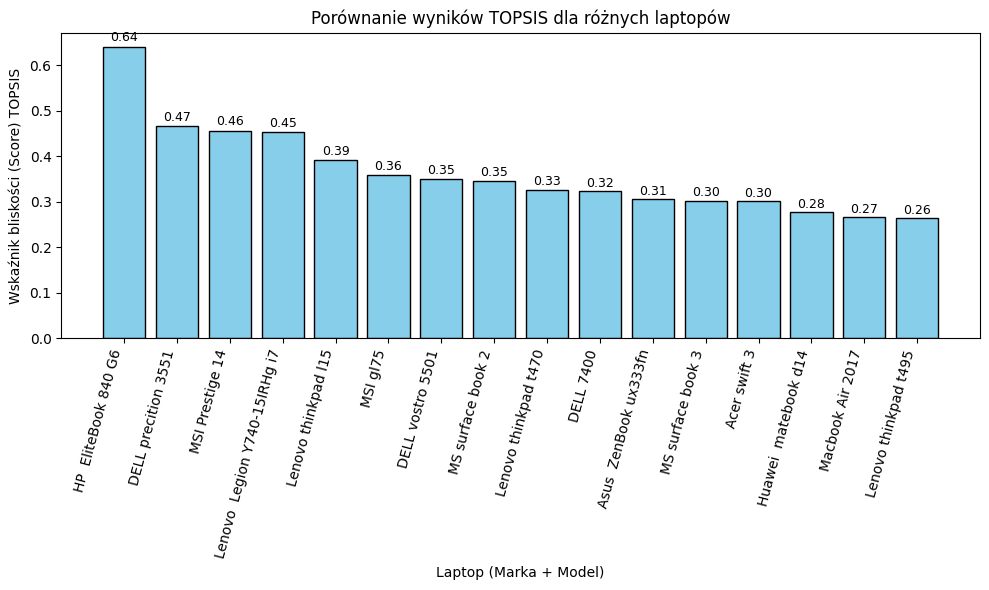

In [36]:
# =====================================================================
# 5. Wykres słupkowy z wynikami TOPSIS
# =====================================================================

# Kopiujemy posortowaną tabelę do zmiennej (by nie modyfikować oryginalnej)
plot_data = final_df.copy()

# Tworzymy etykiety (np. 2-3 kolumny, żeby było krócej na osi)
labels = plot_data["Marka"] + " " + plot_data["Model"]

# Parametry wykresu
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, plot_data["Score"], color="skyblue", edgecolor="black")
plt.xticks(rotation=75, ha="right")
plt.xlabel("Laptop (Marka + Model)")
plt.ylabel("Wskaźnik bliskości (Score) TOPSIS")
plt.title("Porównanie wyników TOPSIS dla różnych laptopów")

# Dodajmy wartości nad słupkami (opcjonalne)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height * 1.01,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

## Wnioski z zastosowania metody TOPSIS

1. **Normalizacja danych wejściowych**  
   Wszystkie wybrane kryteria (np. liczba rdzeni, pamięć RAM, cena, rozdzielczość ekranu) zostały sprowadzone do wspólnej skali dzięki procesowi normalizacji. Pozwoliło to wyeliminować wpływ różnych jednostek pomiaru na wynik końcowy.

2. **Obliczenie wartości ważonych**  
   Po normalizacji wprowadzono wagi, które odzwierciedlają ważność poszczególnych kryteriów w ostatecznej decyzji (np. „Rdzenie”, „Taktowanie”, „RAM” otrzymały wagi 2, czyli są znacznie ważniejsze od pozostałych). Dzięki temu można było w prosty sposób włączyć preferencje użytkownika w obliczenia.

3. **Wyznaczenie punktów idealnych i anty-idealnych**  
   Dla kryteriów, w których „więcej znaczy lepiej” (beneficial), za ideał uznano najwyższe wartości, a dla typu „im mniej, tym lepiej” (cost) – wartości najniższe. Analogicznie zdefiniowano anty-ideały (najgorsze możliwe wyniki).

4. **Obliczenie odległości od punktów odniesienia**  
   Każda alternatywa (laptop) otrzymała dwie miary odległości: jedną względem ideału i drugą względem anty-ideału. Wykorzystano tu odległość euklidesową, która sumuje różnice między wartościami ważonymi a wzorcami.

5. **Obliczenie wskaźnika bliskości**  
   Wskaźnik (Score) opisuje, jak bardzo dany model laptopa jest zbliżony do ideału, a jednocześnie oddalony od anty-ideału. Im wyższa wartość, tym lepsza pozycja w rankingu.

6. **Utworzenie końcowego rankingu**  
   Laptopy posortowano w kolejności malejącej wartości wskaźnika bliskości. Miejsce „1” otrzymuje więc model, który najlepiej równoważy wszystkie kryteria z uwzględnieniem ustalonych wag i rodzajów (beneficial/cost).

---

### Krótka charakterystyka otrzymanych wyników

| Miejsce | Marka       | Model                  | Score    |
|--------:|:------------|:-----------------------|---------:|
| 1       | HP          | EliteBook 840 G6       | 0.638885 |
| 2       | DELL        | precition 3551         | 0.467059 |
| 3       | MSI         | Prestige 14            | 0.456217 |
| 4       | Lenovo      | Legion Y740-15IRHg i7  | 0.453290 |
| 5       | Lenovo      | thinkpad l15           | 0.392607 |
| 6       | MSI         | gl75                   | 0.358507 |
| …       | …           | …                      | …        |
| 16      | Lenovo      | thinkpad t495          | 0.263622 |

Na szczycie rankingu plasuje się **HP EliteBook 840 G6**, który osiąga najwyższy wskaźnik bliskości. Zaraz za nim uplasował się **DELL precition 3551**. Kolejne miejsca (np. **MSI Prestige 14**, **Lenovo Legion Y740**) wskazują, że laptopy te również spełniają większość ustalonych wymagań, choć nie tak dobrze jak lider.

Ostatnie pozycje, takie jak **Lenovo thinkpad t495**, sugerują, że w świetle zdefiniowanych wag i kryteriów (przede wszystkim wydajności procesora, pamięci RAM czy rozdzielczości) nie dorównują urządzeniom z czołówki. Jednak zmiana wag lub dodanie innych kryteriów (np. waga estetyki czy jakości wykonania) może wpłynąć na ich ocenę.

Dzięki TOPSIS uzyskaliśmy **przejrzystą metodę** decyzyjną, która jasno wskazuje, które laptopy są najbardziej dopasowane do wyznaczonych priorytetów. Co ważne, wagi i kryteria można **łatwo modyfikować**, aby dostosować analizę do różnych potrzeb. 